### Prerequisites

Here are some of the libraries needed to run this notebook

In [ ]:
!pip install spacy
!python -m spacy download sv_core_news_sm
!pip install bertopic
!pip install umap-learn
!pip install sentence_transformers
!pip install hdbscan

### Import libraries

In [ ]:
from tqdm import tqdm
import pandas as pd
from bertopic import BERTopic
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
import hdbscan
import numpy as np
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

### Function to calculate coherence (NPMI)

In [2]:
def get_coherence(tm, topics, docs):
    
    documents = pd.DataFrame({
        "doc": docs,
        "id": range(len(docs)),
        "topic": topics
    })
    documents_per_topic = documents.groupby(['topic'], as_index=False).agg({'doc': ' '.join})
    cleaned_docs = tm._preprocess_text(documents_per_topic.doc.values)
    vectorizer = tm.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in tm.get_topic(topic)]
                  for topic in range(len(set(topics))-1)]
    
    c_npmi = CoherenceModel(topics=topic_words,
                                     texts=tokens,
                                     corpus=corpus,
                                     dictionary=dictionary,
                                     coherence='c_npmi')
    
    
    return c_npmi.get_coherence()

### Preprocessing the data

In this project, the data was used as raw and preprocessed. The data was preprocessed using this function below. To save time, I had two separate datasets, raw and preprocessed.

In [ ]:
nlp = spacy.load('sv_core_news_sm', disable=['ner', 'parser', 'tagger', 'lemmatizer'])

def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_stop_words(text):
    doc = nlp(text)
    return [t.text.lower() for t in doc if not t.is_stop and len(t) >= 3 and t.is_alpha]

def preprocess(documents):
    filtered_docs = []
    
    for doc in tqdm(documents, desc="Preprocessing"):
        doc = remove_html_tags(doc)
        doc = remove_stop_words(doc)
        filtered_docs.append(" ".join(doc))
    
    return filtered_docs

### Settings for each experiment

Here the settings for the current experiment are set. Some of the variables are for naming files, but `MIN_CLUSTER_SIZE` was used in the HDBSCAN

In [100]:
CURR_EXPERIMENT = 3
MIN_CLUSTER_SIZE = 150
use_preprocessed = False
CURRENT_EXPERIMENT = f"exp{CURR_EXPERIMENT}_{'preprocessed' if use_preprocessed else 'unprocessed'}_{MIN_CLUSTER_SIZE}"
N_NEIGHBOURS = 15

In [101]:
CURRENT_EXPERIMENT

'exp3_unprocessed_150'

### Load the dataset for the current experiment

In [102]:
if use_preprocessed:
    df = pd.read_json('speeches-full-preprocessed.json.gz', orient='records', lines=True, compression='gzip')
else:
    df = pd.read_json('speeches-full.json.gz', orient='records', lines=True, compression='gzip')

In [103]:
df.head()

,document_id,text,party,year,date
0,GZ091-1,\r\nÄrade ledamöter! Jag vill hälsa er varmt v...,None,2011/12,2011-09-15
1,GZ0910-1,\r\nHerr talman! Veronica Palm har frågat mig ...,M,2011/12,2011-09-29
2,GZ0910-10,\r\nFru talman! Jag vill anmäla till riksdagen...,M,2011/12,2011-09-29
3,GZ0910-11,\r\nFru talman! På temat jämställdhet och kvin...,S,2011/12,2011-09-29
4,GZ0910-12,\r\nFru talman! Jag tackar Carina Moberg för d...,M,2011/12,2011-09-29


In [104]:
docs = df.text.tolist()
years = df.year.tolist()
parties = df.party.tolist()
timestamps = df.date.tolist()

" ".join(docs[0].split()[:20])

'Ärade ledamöter! Jag vill hälsa er varmt välkomna till kammaren. Detta är den dag då riksmötet 2011/2012 formellt öppnar. Men'

### **OPTIONAL** Embed documents

The documents may be be embedded before initializing BERTopic, which saves time when trying different hyperparameters. Otherwise this is done automatically inside BERTopic



In [125]:
# Might be better to use 
# https://huggingface.co/KBLab/sentence-bert-swedish-cased

sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
sentence_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [ ]:
print("Embedding docs")
embeddings = sentence_model.encode(docs, show_progress_bar=True)
embeddings.shape

### Run BERTopic

Here BERTopic is used. The UMAP and HDBSCAN are initialised before BERTopic is used, in order to show that you can use different algorithms. You can skip creating them before BERTopic, and they will be automatically created inside BERTopic

In [ ]:
vectorizer_model = CountVectorizer()

# Init UMAP
umap_model = UMAP(n_neighbors=N_NEIGHBOURS, # lower-value = local structure, higher-value = global structure
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False)

# Init HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=False)

topic_model = BERTopic(umap_model = umap_model,
                       hdbscan_model=hdbscan_model,
                       embedding_model = "paraphrase-multilingual-MiniLM-L12-v2", #sentence_model
                       language='swedish',
                       low_memory=False,
                       verbose=True,
                       top_n_words=10,
                       vectorizer_model=vectorizer_model
                       )

print("Start fit_transform()")
topics, probs = topic_model.fit_transform(docs)

# With pretrained embeddings
#topics, probs = topic_model.fit_transform(docs, embeddings)


### Get coherence for current experiment

In [106]:
%%time
get_coherence(topic_model, topics, docs)

CPU times: total: 26.6 s
Wall time: 6min 14s


4.26324243998861e-05

### Print 20 largest topics

In [107]:
topic_model.get_topic_info().head(20)

,Topic,Count,Name
0,-1,26491,-1_att_det_och_är
1,0,5970,0_det_att_jag_som
2,1,4276,1_att_och_det_är
3,2,3551,2_att_det_är_som
4,3,3082,3_det_att_är_som
5,4,2565,4_att_det_är_och
6,5,2550,5_att_det_och_på
7,6,2247,6_att_som_det_och
8,7,1973,7_att_och_det_som
9,8,1877,8_kvinnor_att_och_det


### Visualize the topics

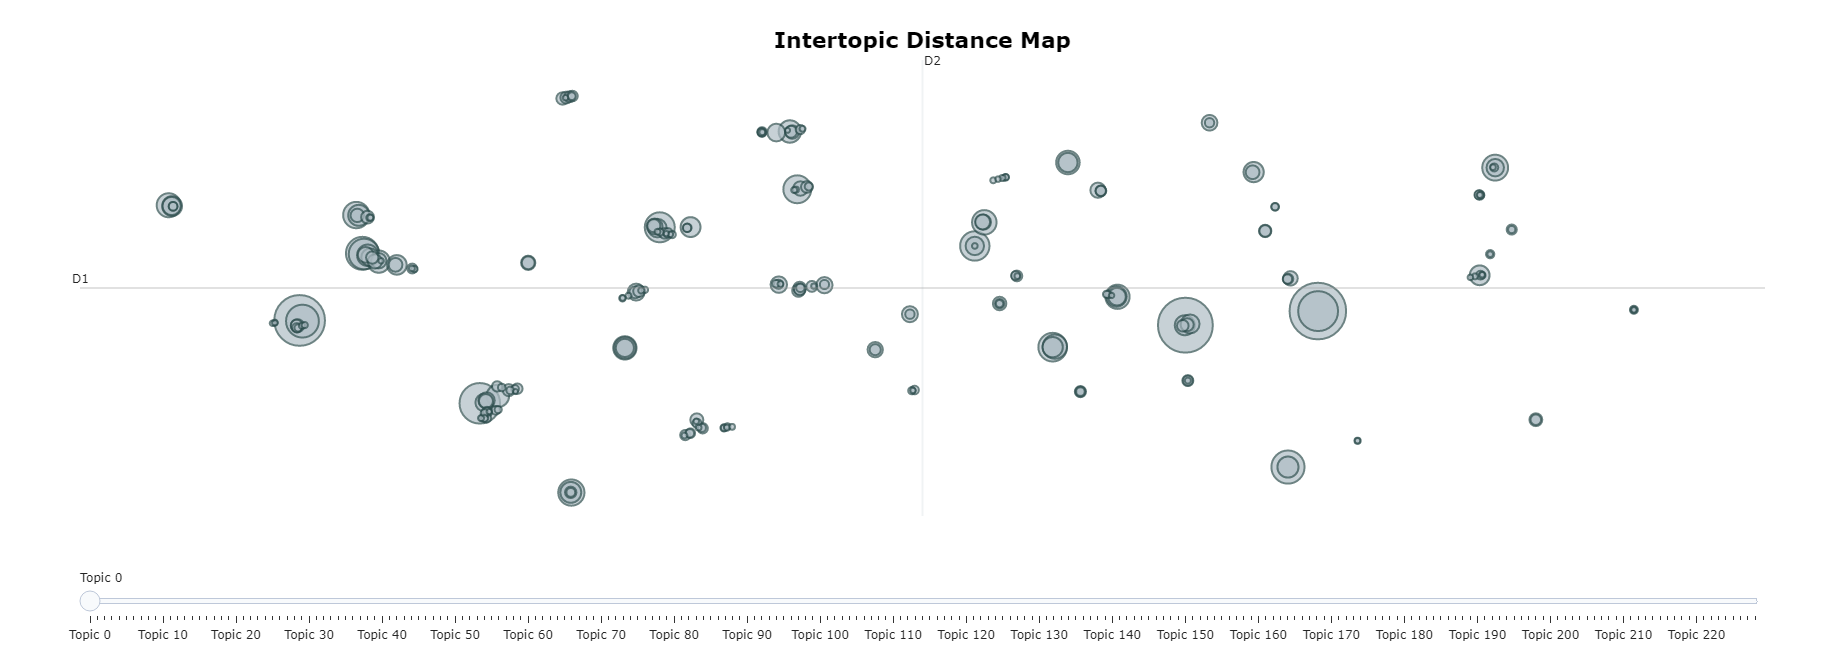

In [368]:
topic_model.visualize_topics()

### Get 5 representative words of the 5 largest topics

- Get number of topics
- Get number of outliers
- Outliers are in topic -1

In [108]:
print('Total number of topics: ', len(set(topic_model.topics_)))
print('Total number of outliers: ', topic_model.get_topic_freq(-1))
for i in range(10):
    print(f'size: {topic_model.get_topic_freq(i)} {[p[0] for p in topic_model.get_topic(i)][:5]}')

Total number of topics:  49
Total number of outliers:  26491
size: 5970 ['det', 'att', 'jag', 'som', 'är']
size: 4276 ['att', 'och', 'det', 'är', 'som']
size: 3551 ['att', 'det', 'är', 'som', 'har']
size: 3082 ['det', 'att', 'är', 'som', 'och']
size: 2565 ['att', 'det', 'är', 'och', 'som']
size: 2550 ['att', 'det', 'och', 'på', 'är']
size: 2247 ['att', 'som', 'det', 'och', 'vi']
size: 1973 ['att', 'och', 'det', 'som', 'är']
size: 1877 ['kvinnor', 'att', 'och', 'det', 'är']
size: 1869 ['att', 'det', 'och', 'är', 'för']


### Find the immigration related topic

::warning:: Can not be used if documents were embedded outside of BERTopic

This was helpful when the immigration-related topic was not among the top 20 topics, can also find similar and interesting topics

In [109]:
topic_model.find_topics('flykting')

([27, 21, 20, 18, 22],
 [0.49000613095397305,
  0.46570784014623207,
  0.44532578329169636,
  0.4343345757188351,
  0.41418658100939276])

## Plot document frequency of immigration related topics


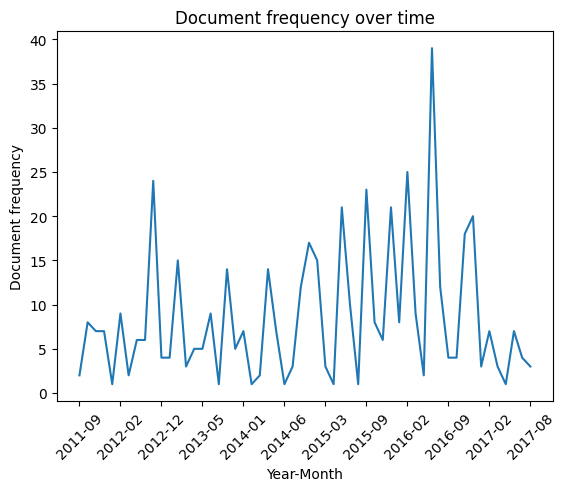

<Figure size 1200x600 with 0 Axes>

In [114]:
import matplotlib.pyplot as plt

immigration_related_topics = [21]

imig_df = pd.DataFrame({'topic': topics, 'text':docs, 'date': timestamps})

imig_df = imig_df.loc[imig_df.topic == immigration_related_topics[0]]
imig_df['year_month'] = imig_df['date'].dt.strftime('%Y-%m')
imig_df.drop(columns=['date'], inplace=True)

# Group the data by year and month
topics_by_year_month = imig_df.groupby('year_month')['topic'].count()
# To make it more readable on the x-axis
tick_locations = topics_by_year_month.index[::5]
tick_labels = topics_by_year_month.index[::5]

# Plot the rolling average as a line chart
plt.title('Document frequency over time')
plt.xlabel('Year-Month')
plt.ylabel('Document frequency')
plt.plot(topics_by_year_month)
plt.xticks(tick_locations, tick_labels, rotation=45)
plt.figure(figsize=(12,6))

plt.show()

# Export df
topics_by_year_month.to_csv(f'{CURRENT_EXPERIMENT}-df.csv')


## Plotting the frequency of immigration related words

In [115]:
immigration_related_words = []

for topic in immigration_related_topics:
    print(f'topic={topic} size={topic_model.get_topic_freq(topic)}')
    print([pair[0] for pair in topic_model.get_topic(topic)])
    immigration_related_words.extend([pair[0] for pair in topic_model.get_topic(topic)])
    print()

immigration_related_words = set(immigration_related_words)

print(immigration_related_words)

topic=21 size=479
['syrien', 'och', 'irak', 'att', 'för', 'är', 'som', 'vi', 'det', 'de']

{'vi', 'det', 'irak', 'de', 'som', 'och', 'är', 'för', 'att', 'syrien'}


##### Choose relevant immigration-related words

In [116]:
immigration_related_words = ['syrien', 'irak']

print("Selected immigration related words:", immigration_related_words)
cv = topic_model.vectorizer_model # Extract the CounterVectorizer used in topic_model
X = cv.transform(docs) # Get the document-term matrix

Selected immigration related words: ['syrien', 'irak']


In [117]:
X.shape

(77326, 218732)

In [118]:
saliences = []
for i in tqdm(range(len(docs)), desc="Calculating frequency of words"):
    f = 0
    for word in immigration_related_words:
        f += X[i, cv.vocabulary_[word]]
    W = np.sum(X[i, :])
    saliences.append(f / W)


Calculating frequency of words: 100%|██████████████████████████████████████████| 77326/77326 [00:44<00:00, 1746.70it/s]


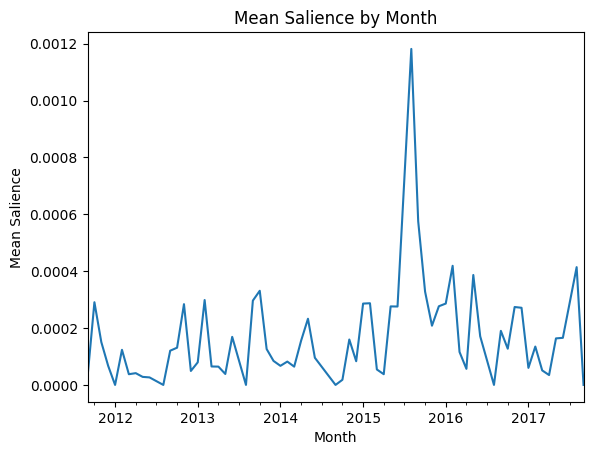

In [119]:
salience_df = pd.DataFrame({'salience':saliences, 'date':timestamps})
salience_df['year_month'] = salience_df['date'].dt.strftime('%Y-%m')
salience_df['year_month'] = pd.to_datetime(salience_df['year_month'])

salience_df.drop(columns=['date'], inplace=True)
df_monthly = salience_df.groupby(pd.Grouper(key='year_month', freq='M'))['salience'].mean()
df_monthly = df_monthly.interpolate()
df_monthly.plot(kind='line')
plt.title('Mean Salience by Month')
plt.xlabel('Month')
plt.ylabel('Mean Salience')
plt.show()

df_monthly.to_csv(f'{CURRENT_EXPERIMENT}-mean-salience.csv')